In this notebook we will be getting densities of the adjacency matrices representing the neurons in different sections of the larva (hemispheres and segments). We will then test if there is any statistical significance between the densities across hemispheres/segments.

In [56]:
import os
import pymaid
import logging
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import seaborn as sns
from itertools import chain, combinations
from upsetplot import plot
from matplotlib import pyplot as plt
from networkx import from_numpy_array, from_pandas_adjacency, number_of_nodes, number_of_edges, density
from graspologic.embed import AdjacencySpectralEmbed
from graspologic.layouts import layout_tsne, layout_umap
from graspologic.plot.plot import networkplot
from graspologic.utils import is_fully_connected, largest_connected_component, is_symmetric, symmetrize
from graspologic.inference import erdos_renyi_test
from statsmodels.stats.proportion import proportion_confint

In [2]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

path = "/Users/kareefullah/Desktop/neurodata/neurodata/platy-data/docs/outputs"

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


Let us first import the annotations table that we made in the `data_summary_v2.ipynb` file

In [3]:
annotations = pd.read_csv(path + "/annotations.csv", index_col=False)
annotations

,skids,side,class,segment,type,group
0,1343291,rc,NaN,head,NaN,NaN
1,1332516,rc,s,head,49.0,NaN
2,1402724,rc,NaN,3,NaN,NaN
3,1462664,rc,NaN,2,NaN,NaN
4,84457,rc,NaN,head,NaN,NaN
...,...,...,...,...,...,...
9192,2256298,NaN,NaN,1,NaN,NaN
9193,2256326,NaN,NaN,1,NaN,NaN
9194,2256339,NaN,NaN,1,NaN,NaN
9195,1602239,NaN,NaN,1,NaN,NaN


For the left and right hemispheres, we make a dictionary where the keys are the annotations `"l"` and `"r"` and the values are the skids that have the respective annotation

In [4]:
hemi_skid_dict = {"l": [], "r": []}
hemi_list = list(annotations["side"])
skids_list = list(annotations["skids"])
for i in range(len(hemi_list)):
    if hemi_list[i] == "N/A":
        continue
    
    if hemi_list[i] in hemi_skid_dict:
        hemi_skid_dict[hemi_list[i]].append(skids_list[i])

For the segments, we make another dictionary where the keys are the annotations `"head" and "pygidium" and "0" and "1" and "2" and "3"` and the values are the skids that have the respective annotation

In [55]:
#use annotations to get skids for segments
segment_skid_dict = {"head": [], "pygidium": [], "0": [], "1": [], "2": [], "3": []}
segment_list = list(annotations["segment"])
skids_list = list(annotations["skids"])
for i in range(len(segment_list)):
    if segment_list[i] == "N/A":
        continue
    
    if segment_list[i] in segment_skid_dict:
        segment_skid_dict[segment_list[i]].append(skids_list[i])

We now make respective adjacency matrices for the skids for each hemisphere

In [6]:
#use for loops to avoid repetition
df_hemis = {"l": None, "r": None}
for key in hemi_skid_dict:
    df_hemis[key] = pymaid.adjacency_matrix(hemi_skid_dict[key])

We do the same here for the skids of the segments

In [7]:
df_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in segment_skid_dict:
    df_segments[key] = pymaid.adjacency_matrix(segment_skid_dict[key])
len(df_segments)

6

We convert the adjacency matrices to networkx objects so we can get the density of these graphs

In [8]:
nx_hemis = {"l": None, "r": None}
for key in df_hemis:
    nx_hemis[key] = from_pandas_adjacency(df_hemis[key], create_using=nx.DiGraph)

In [9]:
nx_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in df_segments:
    nx_segments[key] = from_pandas_adjacency(df_segments[key], create_using=nx.DiGraph)

We then get the densities of these networkx graphs

In [10]:
dens_hemis = {"l": None, "r": None}
for key in nx_hemis:
    dens_hemis[key] = density(nx_hemis[key])

In [11]:
dens_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in nx_segments:
    dens_segments[key] = density(nx_segments[key])

We concatenate the dicts so we can get a barplot of all the dictionaries we have

In [12]:
all_dicts = dens_hemis | dens_segments
print(all_dicts)

{'l': 0.00016728286167760548, 'r': 0.0001874180633044924, 'head': 0.0005528938573921273, 'pygidium': 0.0011678584477269169, '0': 5.643282954207324e-05, '1': 0.0003931168979712669, '2': 0.00045572476791481427, '3': 0.00039734271850725756}


In [13]:
labels = list(all_dicts.keys())
densities = list(all_dicts.values())

[0.00016728286167760548,
 0.0001874180633044924,
 0.0005528938573921273,
 0.0011678584477269169,
 5.643282954207324e-05,
 0.0003931168979712669,
 0.00045572476791481427,
 0.00039734271850725756]

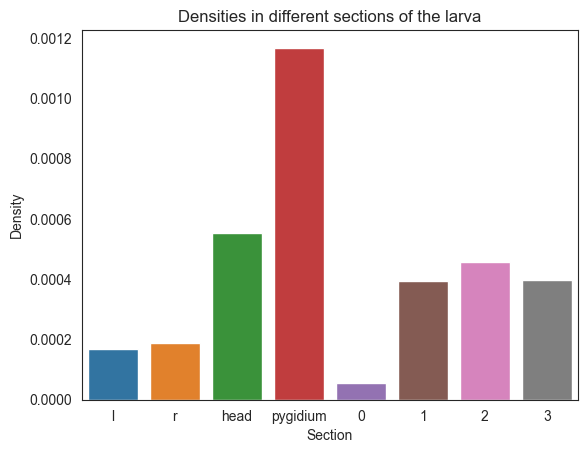

In [14]:
sns.set_style("white")
sns.barplot(x=labels, y=densities) 
plt.title("Densities in different sections of the larva")
plt.xlabel("Section")
plt.ylabel("Density")
plt.savefig(path + "/densities_sections")

Now we are interested in running the erdos-renyi test on left and right adjacency matrices, as well as on all the pairwise combinations of the adjs of the sections. To do this, we must first convert all of our adjs to numpy

In [15]:
#convert pandas df to numpy
np_hemis = {"l": None, "r": None}
for key in df_hemis:
    np_hemis[key] = df_hemis[key].to_numpy()

In [16]:
#same for segments
np_segments = {"head": None, "pygidium": None, "0": None, "1": None, "2": None, "3": None}
for key in df_segments:
    np_segments[key] = df_segments[key].to_numpy()

Let's now run the test for the left and right hemisphere

In [17]:
stat, pvalue, misc = erdos_renyi_test(np_hemis["l"], np_hemis["r"])
pvalue

1.124861758642002e-06

We see that the pvalue is very small, which means that we reject the null hypothesis that the edge probability for the adj of the left hemisphere is not different from the edge probability of the adj of the right hemisphere

The following methods will allow us to plot the density of the sections that we are interested in, as well as the pvalue after running the `erdos_renyi_test`

In [51]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [81]:
def plot_density(pval, label1, label2, misc, ax=None, coverage=0.95):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))

    n_possible_first = misc["possible1"]
    n_possible_second = misc["possible2"]

    density_first = misc["probability1"]
    density_second = misc["probability2"]

    n_edges_first = misc["observed1"]
    n_edges_second = misc["observed2"]

    first_lower, first_upper = proportion_confint(
        n_edges_first, n_possible_first, alpha=1 - coverage, method="beta"
    )
    second_lower, second_upper = proportion_confint(
        n_edges_second, n_possible_second, alpha=1 - coverage, method="beta"
    )

    halfwidth = 0.1
    linewidth = 4
    colors = sns.color_palette("Set2")
    palette = dict(zip([label1, label2], [colors[0], colors[1]]))

    color = palette[label1]
    x = 0
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_first, density_first],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [first_lower, first_upper], color=color, linewidth=linewidth)

    color = palette[label2]
    x = 1
    ax.plot(
        [x - halfwidth, x + halfwidth],
        [density_second, density_second],
        color=color,
        linewidth=linewidth,
    )
    ax.plot([x, x], [second_lower, second_upper], color=color, linewidth=linewidth)

    #yticks = [np.round(density_left, 4), np.round(density_right, 4)]
    yticks = [density_first, density_second]
    ax.set(
        xlabel="Section",
        xticks=[0, 1],
        xticklabels=[label1, label2],
        xlim=(-0.5, 1.5),
        yticks=yticks,
        # ylim=(0, max(right_upper, left_upper) * 1.05),
        ylabel=r"Estimated density ($\hat{p}$)",
        title="{} vs {}; pval: {}".format(label1, label2, pvalue)
    )
    #hard
    ax.plot([label1, label1, label2, label2], [second_upper+0.000005, 0.0002, 0.0002, second_upper+0.000005])
    text = convert_pvalue_to_asterisks(pvalue)
    #hard
    ax.text(0.5, 0.0002+0.0000000001, text, ha='center', va='bottom')
    labels = ax.get_xticklabels()
    for label in labels:
        text_string = label.get_text()
        label.set_color(palette[text_string])
    return ax.get_figure(), ax

(<Figure size 400x600 with 1 Axes>,
 <AxesSubplot:title={'center':'l vs r; pval: 1.124861758642002e-06'}, xlabel='Section', ylabel='Estimated density ($\\hat{p}$)'>)

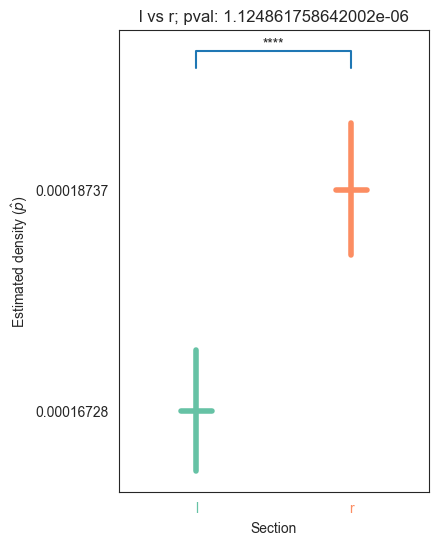

In [82]:
plot_density(pvalue, list(np_hemis.keys())[0], list(np_hemis.keys())[1], misc)